In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

from src.preprocess_data import (
    create_df,
    process_train_df,
    get_id_to_rank,
    get_elo_df
)

### Train set

In [2]:
df = create_df("../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
train = process_train_df(train)

In [3]:
id_to_rank = get_id_to_rank(train)
ranked_ids = list(id_to_rank.keys())

In [4]:
num_players = len(set(train["p1_id"].values).union(set(train["p2_id"].values)))
num_games = len(train)

In [5]:
raw_prior_score = np.arange(num_players, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (
    2 * np.std(raw_prior_score, ddof=1)
)
id_to_prior_score = {k:v for k, v in zip(ranked_ids, prior_score)}

In [6]:
train_sorted = train.sort_values(
    ["abs_rank_diff", "p1_id"], ascending=[False, True]
)

### Test set

For the test set we have the issue that we will encounter players which were not in the training set and for which we need to make a prediction. 

Let's handle the 3 cases for the test set (433 games):

1. Both players were part of the train set (267 games).
2. Only one player was part of the train set (144 games).
3. Neither players were part of the train set (22 games).

In [7]:
test = df.loc[df["date"] >= "2019-01-01"]
test["p1_in_train"] = test["p1_id"].apply(lambda x: x in ranked_ids)
test["p2_in_train"] = test["p2_id"].apply(lambda x: x in ranked_ids)
test["both_p1_p2_in_train"] = test["p1_in_train"] & test["p2_in_train"]
test["one_of_p1_p2_in_train"] = (test["p1_in_train"] & ~test["p2_in_train"]) | (test["p2_in_train"] & ~test["p1_in_train"]) 
test["neither_p1_or_p2_in_train"] = ~test["p1_in_train"] & ~test["p2_in_train"]

test_both = test.copy().loc[test["both_p1_p2_in_train"]]
test_one = test.copy().loc[test["one_of_p1_p2_in_train"]]
test_neither = test.copy().loc[test["neither_p1_or_p2_in_train"]]

assert len(test_both) + len(test_one) + len(test_neither) == len(test), "Incorrect splitting of test set"

In [8]:
train_elo_df = get_elo_df(train)
train_elo_df["prior_score"] = prior_score

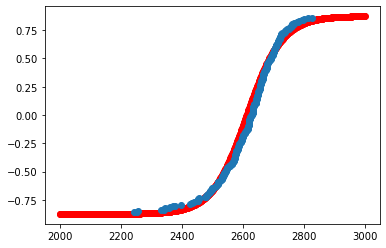

In [9]:
x = np.linspace(2000, 3000, 1000)
train_elo_mean = train_elo_df["elo"].mean()

def get_prior_score_from_elo(elo_score):
    return (1/(1 + np.exp(-0.0175*(elo_score - train_elo_mean))) - 0.5)*1.75

y = get_prior_score_from_elo(x)
plt.scatter(x, y, color="red");
plt.scatter(train_elo_df["elo"], train_elo_df["prior_score"]);

#### 1. Both players were part of the train set

In [10]:
test_both["p1_prior_rank"] = test_both["p1_id"].apply(lambda x: id_to_rank[x])
test_both["p2_prior_rank"] = test_both["p2_id"].apply(lambda x: id_to_rank[x])

#### 2. Only one player was part of the train set

In [11]:
test_one["p1_prior_rank"] = 1000  # TODO: fix this up
test_one.loc[test_one["p1_in_train"], "p1_prior_rank"] = test_one.loc[test_one["p1_in_train"], "p1_id"].apply(lambda x: id_to_rank[x])

test_one["p2_prior_rank"] = 1000  # TODO: fix this up
test_one.loc[test_one["p2_in_train"], "p2_prior_rank"] = test_one.loc[test_one["p2_in_train"], "p2_id"].apply(lambda x: id_to_rank[x])

test_one["p1_prior_score"] = test_one["p1_elo"].apply(lambda x: get_prior_score_from_elo(x))
test_one["p2_prior_score"] = test_one["p2_elo"].apply(lambda x: get_prior_score_from_elo(x))

#### 3. Neither players were part of the train set

We need to assign the players we haven't seen before a prior score. We will use their current elo to give them a prior score roughly in line with that from the training data.

When constructing the prior score we used the "rank" of the players in the training set and so we need to map that now for new players in the test set where we only have a elo rating and not a ranking.

In [12]:
test_neither["p1_prior_score"] = test_neither["p1_elo"].apply(lambda x: get_prior_score_from_elo(x))
test_neither["p2_prior_score"] = test_neither["p2_elo"].apply(lambda x: get_prior_score_from_elo(x))

### Set-up model and fit

In [13]:
ordered_model = pystan.StanModel("../stan_models/ordered_logistic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de204a1e61be46b05f2e29bdbf4b0685 NOW.


In [14]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "player_1_rank": train_sorted["p1_prior_rank"].values.astype(int),
    "player_2_rank": train_sorted["p2_prior_rank"].values.astype(int),
    "player_1_white": train_sorted["p1_white"].values.astype(int),
    "b_mu": 0.0,
    "b_scale": 0.5,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5,
    "c_mu": np.array([-1.25, 1.25]),
    "c_scale": 0.5,
    "w_mu": 5,
    "w_scale": 0.25,
    "fit_model": 1,
    "y": train_sorted["p1_outcome"].values,
    
    # 1. both players in test set:
    "num_test_both_games": len(test_both),
    "p1_test_both_rank": test_both["p1_prior_rank"].values.astype(int),
    "p2_test_both_rank": test_both["p2_prior_rank"].values.astype(int),
    "p1_test_both_white": test_both["p1_white"].values.astype(int),
    
    # 2. one player in test set:
    "num_test_one_games": len(test_one),
    "p1_in_train": test_one["p1_in_train"].values.astype(int),
    "p2_in_train": test_one["p2_in_train"].values.astype(int),
    "p1_test_one_rank": test_one["p1_prior_rank"].values.astype(int),
    "p2_test_one_rank": test_one["p2_prior_rank"].values.astype(int),
    "p1_test_one_prior_score": test_one["p1_prior_score"].values.astype(int),
    "p2_test_one_prior_score": test_one["p2_prior_score"].values.astype(int),
    "p1_test_one_white": test_one["p1_white"].values.astype(int),
    
    # 3. neither of players in test set:
    "num_test_neither_games": len(test_neither),
    "p1_test_neither_prior_score": test_neither["p1_prior_score"].values.astype(int),
    "p2_test_neither_prior_score": test_neither["p2_prior_score"].values.astype(int),
    "p1_test_neither_white": test_neither["p1_white"].values.astype(int),
}

In [15]:
fit = ordered_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### TODO: don't name `ordered_params`

In [16]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [17]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b,1.163,0.083,1.007,1.321,0.002,0.001,2137.0,2123.0,2142.0,2788.0,1.00
1,w,1.277,0.095,1.092,1.447,0.002,0.001,2942.0,2942.0,2951.0,2523.0,1.00
2,c[0],-0.708,0.071,-0.840,-0.577,0.001,0.001,2760.0,2724.0,2756.0,2472.0,1.00
3,c[1],2.027,0.087,1.874,2.198,0.002,0.001,2648.0,2648.0,2647.0,3132.0,1.00
4,sigma_a,0.182,0.085,0.013,0.323,0.004,0.003,553.0,553.0,560.0,1047.0,1.01
5,raw_a[0],0.232,1.002,-1.742,1.993,0.017,0.017,3589.0,1700.0,3563.0,2397.0,1.00
6,raw_a[1],-0.019,1.004,-1.944,1.771,0.014,0.018,5070.0,1608.0,5074.0,2935.0,1.00
7,raw_a[2],0.354,0.857,-1.240,1.961,0.014,0.013,3993.0,2310.0,4021.0,2194.0,1.00
8,raw_a[3],0.251,0.903,-1.624,1.790,0.015,0.014,3656.0,2026.0,3723.0,2375.0,1.00
9,raw_a[4],-0.212,1.016,-1.947,1.882,0.015,0.018,4663.0,1563.0,4673.0,2501.0,1.00


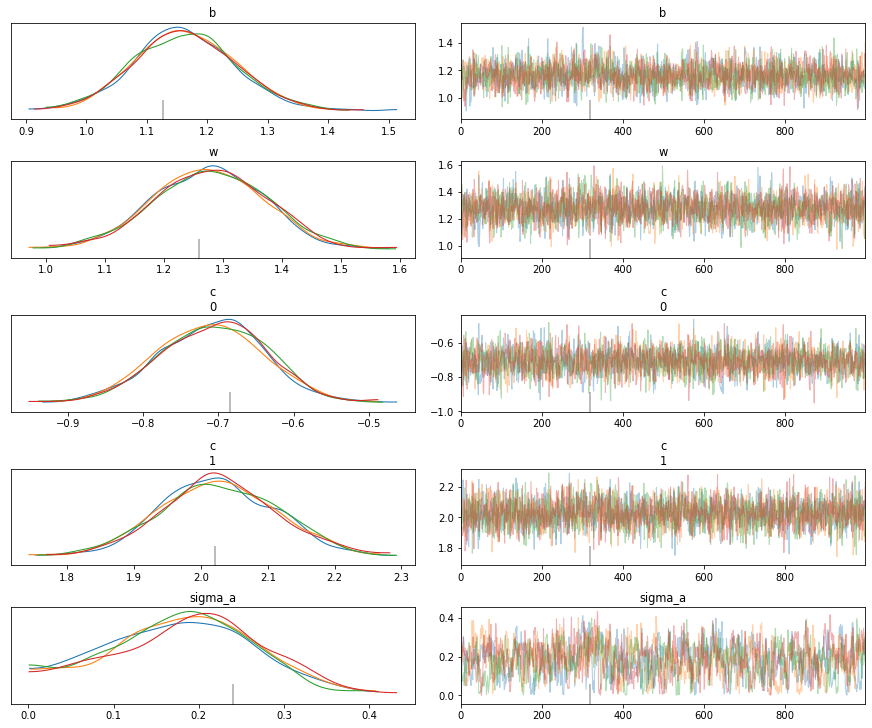

In [18]:
arviz.plot_trace(inference_data, var_names=["b", "w", "c", "sigma_a"]);

### Plotting

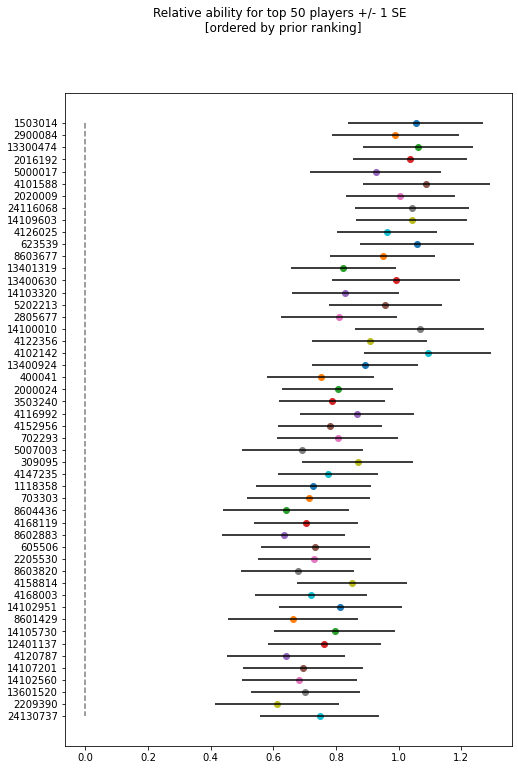

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 50

for i in range(plot_top_n_players):
    a_mean = params["a"][:, i].mean()
    a_sd = float(
        summary_df.loc[
            summary_df["parameter"] == f"a[{i}]", "sd"
        ]
    )
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)

plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.suptitle(
    f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]"
)
plt.yticks(range(1, plot_top_n_players + 1), ranked_ids[:plot_top_n_players]);

### Outcomes

In [20]:
def get_class_probs(params, param_name, class_levels=[1, 2, 3]):
    out = []
    for l in class_levels:
        out.append(np.sum(params[param_name] == l, 0))
    out = np.array(out).T
    out_prob = out / np.mean(out.sum(1))
    return out_prob

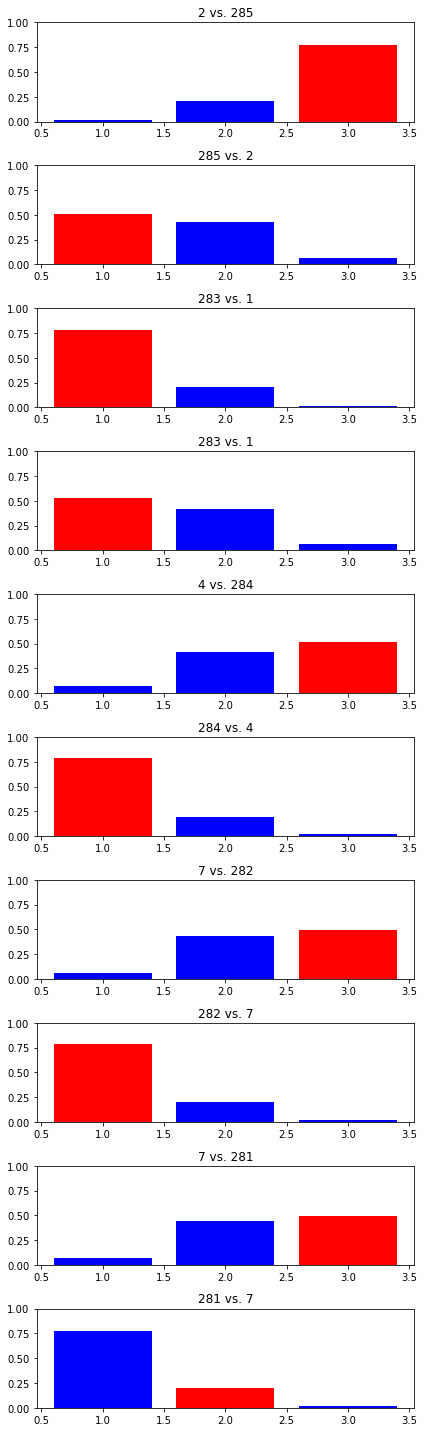

In [21]:
train_cls_probs = get_class_probs(params, "ypred")

plot_n = 10
reverse = False
colors = ["blue"] * 3

plot_df = (
    train_sorted
    if not reverse
    else train_sorted.sort_values(
        ["abs_rank_diff", "p1_id"], ascending=[True, False]
    )
)
ranks = [
    f"{a} vs. {b}"
    for a, b in zip(
        train_sorted["p1_prior_rank"].values.astype(int),
        train_sorted["p2_prior_rank"].values.astype(int),
    )
]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[train_sorted["p1_outcome"].values[i] - 1] = "red"
    ax[i].bar(range(1, 4), train_cls_probs[i, :], color=bar_colors)
    ax[i].set_title(f"{ranks[i]}")
    ax[i].set_ylim(0, 1)
plt.tight_layout();

### Accuracy on train set

In [22]:
def print_results(df, cls_pred, prefix):
    d0 = np.mean(np.abs(df["p1_outcome"] - cls_pred) == 0)
    d1 = np.mean(np.abs(df["p1_outcome"] - cls_pred) == 1)
    d2 = np.mean(np.abs(df["p1_outcome"] - cls_pred) == 2)
    print(f"{prefix} - exact: {d0:.2f}, out by one: {d1:.2f}, out by two: {d2:.2f}")

In [23]:
cls_pred = np.argmax(train_cls_probs, 1) + 1

print_results(train_sorted, cls_pred, "Train")

Train - exact: 0.55, out by one: 0.44, out by two: 0.01


### Accuracy on test set

In [24]:
test_both_cls_probs = get_class_probs(params, "ypred_test_both")
cls_pred_test_both = np.argmax(test_both_cls_probs, 1) + 1
print_results(test_both, cls_pred_test_both, "Test both")

Test both - exact: 0.55, out by one: 0.43, out by two: 0.01


In [25]:
test_one_cls_probs = get_class_probs(params, "ypred_test_one")
cls_pred_test_one = np.argmax(test_one_cls_probs, 1) + 1
print_results(test_one, cls_pred_test_one, "Test one")

Test one - exact: 0.48, out by one: 0.49, out by two: 0.03


In [26]:
test_neither_cls_probs = get_class_probs(params, "ypred_test_neither")
cls_pred_test_neither = np.argmax(test_neither_cls_probs, 1) + 1
print_results(test_neither, cls_pred_test_neither, "Test neither")

Test neither - exact: 0.41, out by one: 0.59, out by two: 0.00


In [27]:
overall_df = pd.DataFrame()
overall_df["p1_outcome"] = np.concatenate([test_both["p1_outcome"].values, 
                                           test_one["p1_outcome"].values, 
                                           test_neither["p1_outcome"].values
                                          ])
cls_preds_test = np.concatenate([cls_pred_test_both, cls_pred_test_one, cls_pred_test_neither])

In [28]:
print_results(overall_df, cls_preds_test, "Overall test")

Overall test - exact: 0.52, out by one: 0.46, out by two: 0.02


### Ad-hoc analysis

Relative player ability is modelled as:

$$a_i \sim \mathcal{N}(b \, * \, \text{prior_score}_i, \sigma_a)$$

**What is the difference between `raw_a` and `a` for a player?**


`raw_a` is kind of like an unpooled estimate of relative player ability based on their data alone. As part of the hierarchical model and the transformation:

`a` = `b` * `prior_score` + `sigma_a` * `raw_a`

then it represents the per-player adjustment (both mean and std) on top of the shared information contained in the prior and `sigma_a`.


`a` is thus partially-pooled estimate after taking advantage of the shared information we have i.e. by learning both `sigma_a` which tells us how variable player ability is and `b` which tells us how informative the prior ranking is. 

Both `sigma_a` and `b` are learned across all players and so "share" information.

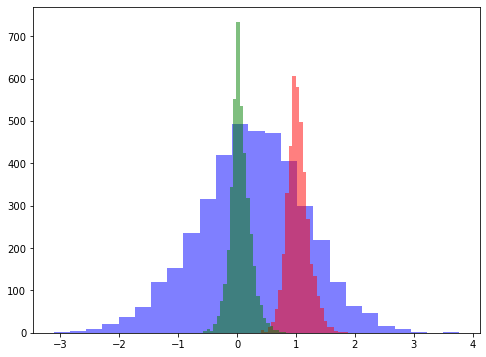

In [39]:
player_id = 3
a_id_prior = prior_score[player_id]

raw_a_id = params["raw_a"][:, player_id]
b = params["b"]
a_id_posterior = params["a"][:, player_id]
sigma_a = params["sigma_a"]

bins = 25
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)
ax.hist(raw_a_id, bins=bins, color="blue", alpha=0.5);
ax.hist(a_id_posterior, bins=bins, color="red", alpha=0.5);
ax.hist(raw_a_id*sigma_a, bins=bins, color="green", alpha=0.5);

In [40]:
summary_df.loc[summary_df["parameter"] == f"raw_a[{player_id}]"]

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
8,raw_a[3],0.251,0.903,-1.624,1.79,0.015,0.014,3656.0,2026.0,3723.0,2375.0,1.0


In [41]:
summary_df.loc[summary_df["parameter"] == f"a[{player_id}]"]

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
293,a[3],1.035,0.182,0.705,1.398,0.004,0.003,2369.0,2112.0,2505.0,2214.0,1.0


In [57]:
all_ids = list(train["p1_id"].values) + list(train["p2_id"].values)

id_to_games_played = {k:0 for k in ranked_ids}
for i in all_ids:
    id_to_games_played[i] += 1

In [60]:
for i in range(num_players):
    raw_a_mean, raw_a_std = np.mean(params["raw_a"][:, i]), np.std(params["raw_a"][:, i])
    player_id = ranked_ids[i]
    print(f"{player_id}: mean: {raw_a_mean:.4f}, std: {raw_a_std:.4f}, num games: {id_to_games_played[player_id]}")

1503014: mean: 0.2323, std: 1.0020, num games: 6
2900084: mean: -0.0187, std: 1.0043, num games: 10
13300474: mean: 0.3537, std: 0.8568, num games: 46
2016192: mean: 0.2506, std: 0.9033, num games: 35
5000017: mean: -0.2117, std: 1.0161, num games: 4
4101588: mean: 0.5780, std: 0.9103, num games: 31
2020009: mean: 0.2212, std: 0.8646, num games: 42
24116068: mean: 0.4288, std: 0.8802, num games: 40
14109603: mean: 0.4569, std: 0.8403, num games: 67
4126025: mean: 0.0915, std: 0.8196, num games: 68
623539: mean: 0.6222, std: 0.8466, num games: 65
8603677: mean: 0.1104, std: 0.8525, num games: 41
13401319: mean: -0.4750, std: 0.8526, num games: 42
13400630: mean: 0.3805, std: 0.9265, num games: 14
14103320: mean: -0.3881, std: 0.8660, num games: 40
5202213: mean: 0.2786, std: 0.8729, num games: 42
2805677: mean: -0.3766, std: 0.9083, num games: 20
14100010: mean: 0.8988, std: 0.8898, num games: 57
4122356: mean: 0.1643, std: 0.9128, num games: 30
4102142: mean: 1.1306, std: 0.8434, num g